In [138]:
import numpy as np
from catan import Catan, CatanException, get_random_dice_arrangement, Player, simulate_game, simulate_game_and_save
import matplotlib.pyplot as plt
from itertools import repeat
%matplotlib inline

In [139]:
class Goal:
    def __init__(self, tasks=[], x=-1, y=-1):
        self.tasks = list(tasks)
        self.x, self.y = x, y

class CityGoal(Goal):
    def estimate_weight(self, player, htime):
        return 1 / (0.1+htime) # TODO

class SettlementGoal(Goal):
    def estimate_weight(self, player, htime):
        return 1 / (0.1+htime) # TODO

class PortGoal(SettlementGoal):
    def estimate_weight(self, player, htime):
        return 1 / (0.1+htime) # TODO

class CardGoal(Goal):
    def estimate_weight(self, player, htime):
        return 0 # TODO


class Task:
    def __init__(self, x=-1, y=-1):
        self.x, self.y = x, y
    
    def make_trading_rule(self, player):
        return lambda x,y,z: (x,y,z)  # TODO
    
    def execute(self, player):
        pass

class CardTask(Task):
    resources_needed = (1, 2, 2)
    def execute(self, player):
        if player.if_can_buy("card"):
            player.buy("card")
            return True
        return False

class CityTask(Task):
    resources_needed = (0, 3, 3)
    def execute(self, player):
        if player.if_can_buy("city"):
            player.buy("city", self.x, self.y)
            return True
        return False

class SettlementTask(Task):
    resources_needed = (2, 1, 1)
    def execute(self, player):
        if player.if_can_buy("settlement"):
            print("building settlement!")
            player.buy("settlement", self.x, self.y)
            player.available_locations.add((self.x, self.y))
            return True
        return False

class RoadTask(Task):
    resources_needed = (1, 1, 0)
    def execute(self, player):
        if player.if_can_buy("road"):
            player.buy("road", self.x, self.y)
            player.available_locations.add(self.x)
            player.available_locations.add(self.y)
            return True
        return False


In [135]:
def encode_loc(x, y):
    return y * 5 + x

def decode_loc(i):
    return i % 5, i // 5

def hitting_time_until_task(player, task):
    # should definitely be cached
    w, b, g = task.resources_needed
    w_curr, b_curr, g_curr = player.resources
    if w_curr >= w and b_curr >= b and g_curr >=g:
        return 0
    trade_rule = task.make_trading_rule(player)
    resources_per_roll = player.board.get_resources()
    P = transition_matrix(resources_per_roll, trade_rule)
    indexes, beta = hitting_time(P, w, b, g)
    encoded = int(encode(w_curr, b_curr, g_curr))
    i = indexes.index(encoded)
    return beta[i]

def calculate_hitting_time(player, goal):
    return sum(hitting_time_until_task(player, task) for task in goal.tasks)

def choose_goal_to_pursue(player, goals):
    weights = []
    for goal in goals:
        time_to_goal = calculate_hitting_time(player, goal)
        weight = goal.estimate_weight(player, time_to_goal)
        weights.append(weight)
    return goals[np.argmax(weights)]

def distance(loc1, loc2):
    return abs(loc1[0] - loc2[0]) + abs(loc1[1] - loc2[1])

def get_shortest_path_to_location(available_locations, x, y):
    """ Returns a list of ((x1, y1), (x2, y2)) tuples, each symbolizing a road to be built"""
    # this is the closest point to the destination (x, y)
    start = min(available_locations, key=lambda loc: distance(loc, (x, y)))
    # right now we assume that the best path to take is by going diagonally across the board
    #     that way we maximize new available locations that have 4 neighboring resources
    #     maybe ideally it would take into account where the other roads are and build in an opposite direction to them or smth
    amount_to_go = [x - start[0], y - start[1]] # (amount_to_go_right, amount_to_go_up)
    points_to_hit = [start]
    curr = list(start) # so that it is mutable, will need to cast to tuple before recording
    end  = [x, y]
    while curr != end:
        # if i == 0, we are moving left/right, if i == 1, we are moving down/up
        # this will move horizontally, then diagonally
        i = 0 if abs(amount_to_go[0]) >= abs(amount_to_go[1]) else 1
        amount = amount_to_go[i] // abs(amount_to_go[i])
        curr[i] += amount
        amount_to_go[i] -= amount
        points_to_hit.append(tuple(curr))
    # Now points_to_hit is populated with (x,y) tuples of all the locations we're going to hit
    return list(zip(points_to_hit, points_to_hit[1:]))


def generate_road_tasks_to_point(player, x, y):
    """If all building/road buys were made through the Task API, then 
            available_locations is a set of (x,y) tuples with points we can build roads from"""
    cheapest_roads_to_get_there = get_shortest_path_to_location(player.available_locations, x, y)
    tasks = []
    for road in cheapest_roads_to_get_there:
        tasks.append(RoadTask(road[0], road[1]))
    return tasks

def generate_settlement_goal_at_location(player, x, y):
    tasks = generate_road_tasks_to_point(player, x, y)
    tasks.append(SettlementTask(x, y))
    return SettlementGoal(tasks, x, y)

def generate_port_goal_at_location(player, x, y):
    tasks = generate_road_tasks_to_point(player, x, y)
    tasks.append(SettlementTask(x, y))
    return PortGoal(tasks, x, y)

def generate_all_settlement_port_goals(player):
    stlments = set(player.board.settlements)
    cities = set(player.board.cities)
    # all possible places to place new settlements
    possible = set((x,y) 
                for x in range(5) for y in range(5)
                if     encode_loc(x,y) not in stlments
                   and encode_loc(x,y) not in cities)
    ports = set([(0,0), (0,4), (4,0), (4,4)])
    goals = []
    for x, y in possible:
        if (x,y) in ports:
            goals.append(generate_port_goal_at_location(player,x,y))
        else:
            goals.append(generate_settlement_goal_at_location(player,x,y))
    
    return goals

def generate_all_city_goals(player):
    goals = []
    all_settlements = player.board.settlements
    for x, y in map(decode_loc, all_settlements):
        task = CityTask(x, y)
        goals.append(CityGoal([task], x, y))
    return goals


def generate_all_possible_goals(player):
    # Add all the possible settlment only goals (no building of roads)
    settlements = generate_all_settlement_goals(player)
    # Add all the possible city goals
    cities = generate_all_city_goals(player)
    # Add all the possible port goals
    ports = generate_all_port_goals(player)
    # Add all the card goal
    cards = [
        CardGoal([CardTask()])
    ]
    return settlements + cities + ports + cards

def action(self):
    if self.board.settlements == []:
        # What are we to do on our first turn?
        x, y = self.preComp
        self.available_locations = set()
        settlementTask = SettlementTask(x, y)
        settlementTask.execute(self)
    print("i ", end="")
    possible_goals = generate_all_possible_goals(self)
    self.current_goal = choose_goal_to_pursue(self, possible_goals)
    tasks = self.current_goal.tasks
    if len(tasks) == 0:
        print("Should not occur: no tasks in goal")

    while len(tasks) > 0:
        curr_task = tasks[0]
        if curr_task.execute(self):
            tasks.pop(0)
        else:
            break # Could not complete our task for some reason


def planBoard(baseBoard):
    return 2, 3
    resources_per_tile = {}
    for v in range(baseBoard.max_vertex):
        loc = baseBoard.get_vertex_location(v)
        resources_per_tile[loc] = (set(), 0)
        for i in [-1, 0]: 
            for j in [-1,0]:
                neighbor = (loc[0]+i, loc[1] + j)
                if neighbor.is_tile():
                    resources_per_tile[loc][0].add(baseBoard.resources[neighbor])
                    resources_per_tile[loc][1] += 1
    optimal_loc = max(resources_per_tile.keys(), key = lambda x: len(resources_per_tile[x][0]) + resources_per_tile[x][1])
    return opt_loc

Drawing...


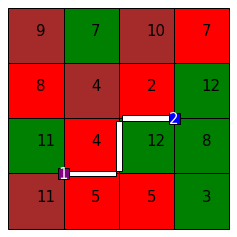

In [132]:
from hittingtime import *
import numpy as np
from catan import Catan, CatanException, get_random_dice_arrangement, Player, simulate_game, simulate_game_and_save
import matplotlib.pyplot as plt
from itertools import repeat
%matplotlib inline

available_locations_roads = []
# building = None
# x1,y1 = 0

costs = np.array([[2, 1, 1],
                  [1, 2, 2],
                  [0, 3, 3],
                  [1, 1, 0]])

num_trials = 1

width, height = 4,4
dice = get_random_dice_arrangement(width, height)
resources = np.random.randint(0, 3, (height, width))
board = Catan(dice, resources, [6], [13], [(6, 7), (7, 12), (12, 13)])
board.draw()

turn: 183
points: 5
dice roll: 8
resources: [ 6.  0.  6.]
Drawing...
[[17], [17], [17], [17], [17], [17], [17], [17], [17], [17], [17], [17], [17], [17], [17], [17], [17], [17], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []

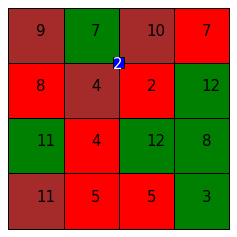

In [136]:
settlements, cities, roads, hands, live_points, dice_rolls = simulate_game_and_save(action, planBoard, board)

def draw(t):
    t = int(t)
    live_board = Catan(board.dice, board.resources, [], [])
    live_board.settlements = settlements[t]
    live_board.cities = cities[t]
    live_board.roads = roads[t]
    print("turn:", t)
    print("points:", live_points[t])
    print("dice roll:", dice_rolls[t])
    print("resources:", hands[t])
    live_board.draw()

from ipywidgets import *
interact(draw, t=(0, len(live_points) - 1, 1))
print(settlements)

In [27]:
input()

hello


'hello'

In [97]:
get_shortest_path_to_location([(0,0), (0,2)], 4,4)

[((0, 2), (1, 2)),
 ((1, 2), (2, 2)),
 ((2, 2), (3, 2)),
 ((3, 2), (3, 3)),
 ((3, 3), (4, 3)),
 ((4, 3), (4, 4))]